# Fooled colored MNIST (Try to put more focus on colors instead of the shape of the digits)
The idea is to create a model, which should be able to asses, if the digit in the image is a low or a high number. The image dataset of colored digits is divided into three parts namely the train, validation and test datasets. In the train and validatin datasets, the low numbers are colored in red and the high numbers are colored in green. In the test dataset, the colors are random. If the model is able to recognize the value of the digits from it's shape, the performance should be nearly equal as the performance on the train and validation datasets. The hypothesis is, that the model will learn to separate low from high digits based on their color and therefore will fail on the test dataset.

## Setup environment

In [146]:
# basic modules
import numpy as np
import matplotlib.pyplot as plt
import sys

# pytorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision import __version__ as torchvision_version

%load_ext autoreload
%autoreload 2

print("Torch version:", torch.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Torch version: 1.13.0a0+d0d6b1f


In [147]:
# include plots in notebook
%matplotlib inline

In [148]:
# check environment
print("Python version: ", sys.version)
print("Pytorch version: ", torch.__version__)
print("Torchvision version: ", torchvision_version)

!nvidia-smi

Python version:  3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:10) 
[GCC 10.3.0]
Pytorch version:  1.13.0a0+d0d6b1f
Torchvision version:  0.14.0a0
Mon Jan  9 05:04:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:34:00.0 Off |                    0 |
| N/A   34C    P0    50W / 350W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+--

## Prepare dataset

In [149]:
from utils.mnist_preprocessing import *
from utils.mnist_plotting import *

# dataset parameters
DATASET_BATCH_SIZE = 128
DATASET_SHUFFLE = True

In [150]:
import clip

model, preprocess = clip.load("RN50")

MNIST dataset already exists
Preparing Colored MNIST
Scanning train image 0/60000
Scanning train image 5000/60000
Scanning train image 10000/60000
Scanning train image 15000/60000
Scanning train image 20000/60000
Scanning train image 25000/60000
Scanning train image 30000/60000
Scanning train image 35000/60000
Scanning train image 40000/60000
Scanning train image 45000/60000
Scanning validation image 50000/60000
Scanning validation image 55000/60000
Scanning test image 0/10000
Scanning test image 5000/10000
Scanning test_fool image 0/10000
Scanning test_fool image 5000/10000
Preparing Colored MNIST
Scanning train image 0/60000
Scanning train image 5000/60000
Scanning train image 10000/60000
Scanning train image 15000/60000
Scanning train image 20000/60000
Scanning train image 25000/60000
Scanning train image 30000/60000
Scanning train image 35000/60000
Scanning train image 40000/60000
Scanning train image 45000/60000
Scanning validation image 50000/60000
Scanning validation image 55000

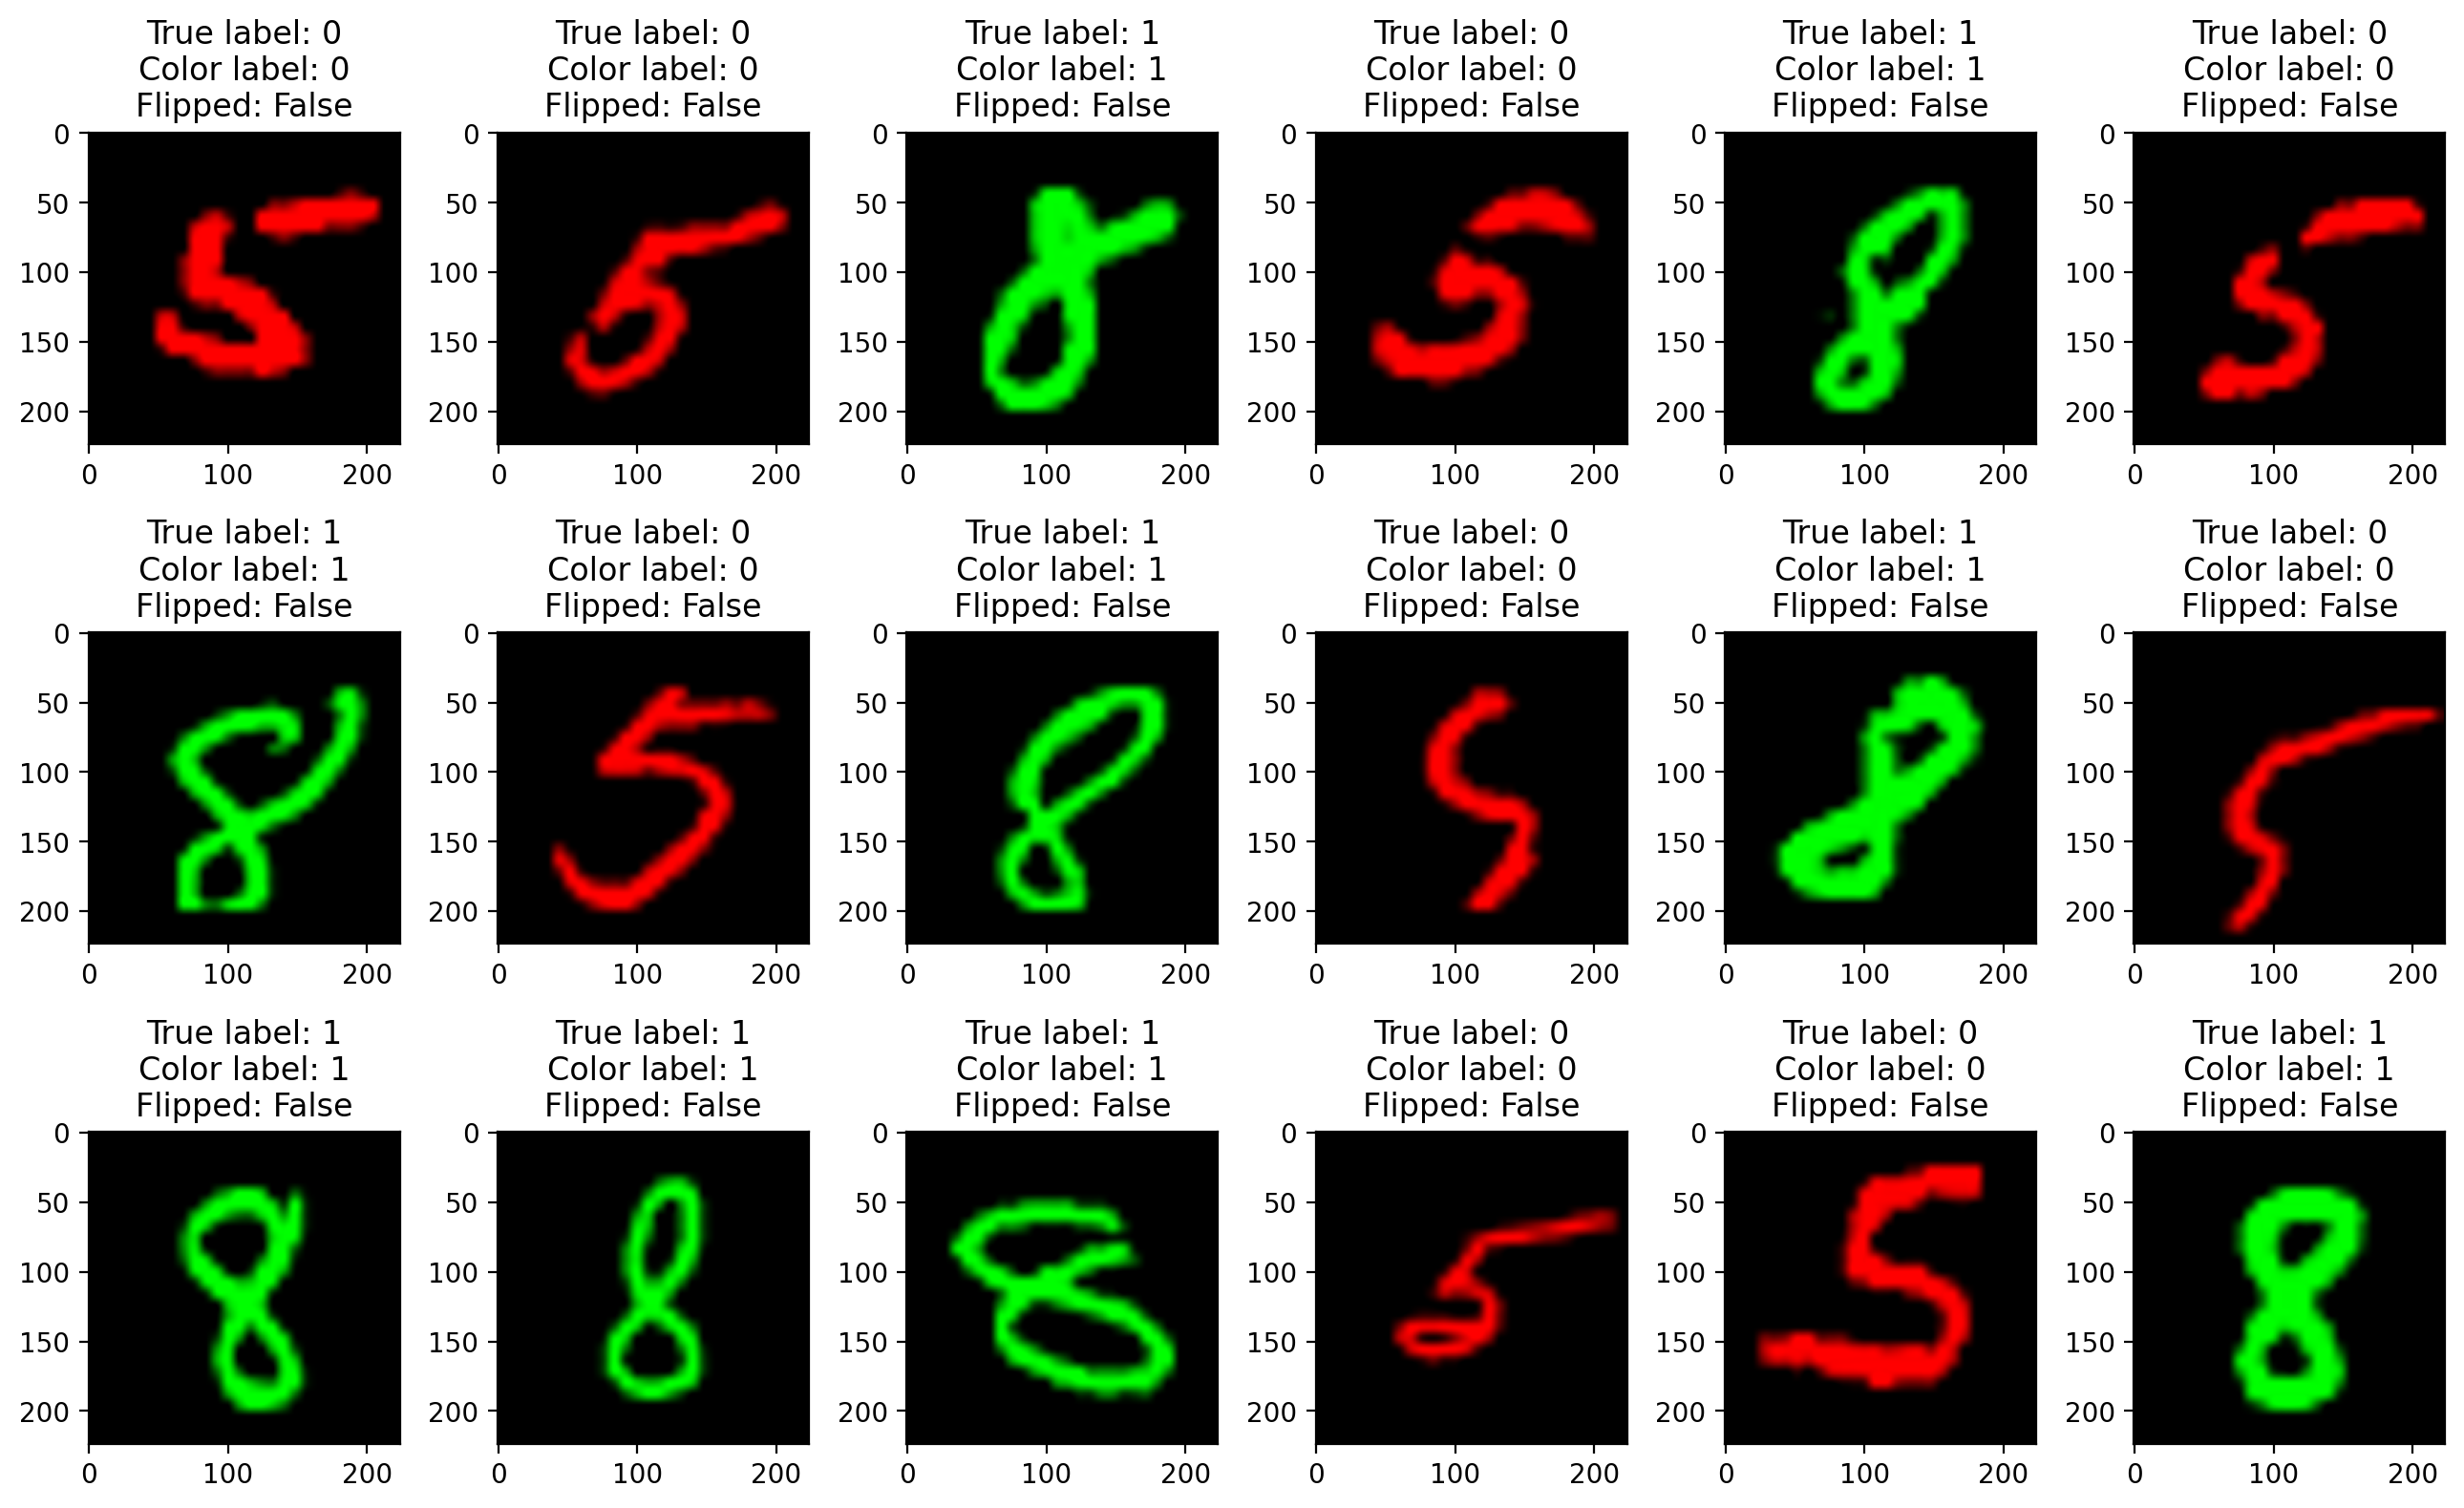

In [151]:
# create and select training dataset
# original 10 class problem
DatasetMNIST(root='./data',
                            env='train',
                            color=True,
                            opt_postfix="10classes",
                            first_color_max_nr=4,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
DatasetMNIST(root='./data',
                            env='train',
                            color=False,
                            opt_postfix="10classes",
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
train_set = DatasetMNIST(root='./data',
                            env='train',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

train_loader = torch.utils.data.DataLoader(dataset=train_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE,
                                            num_workers=10)

print("Number of samples: ", len(train_set))
plot_digits(train_set, preprocess)

MNIST dataset already exists
MNIST dataset already exists
MNIST dataset already exists
Number of samples:  1858


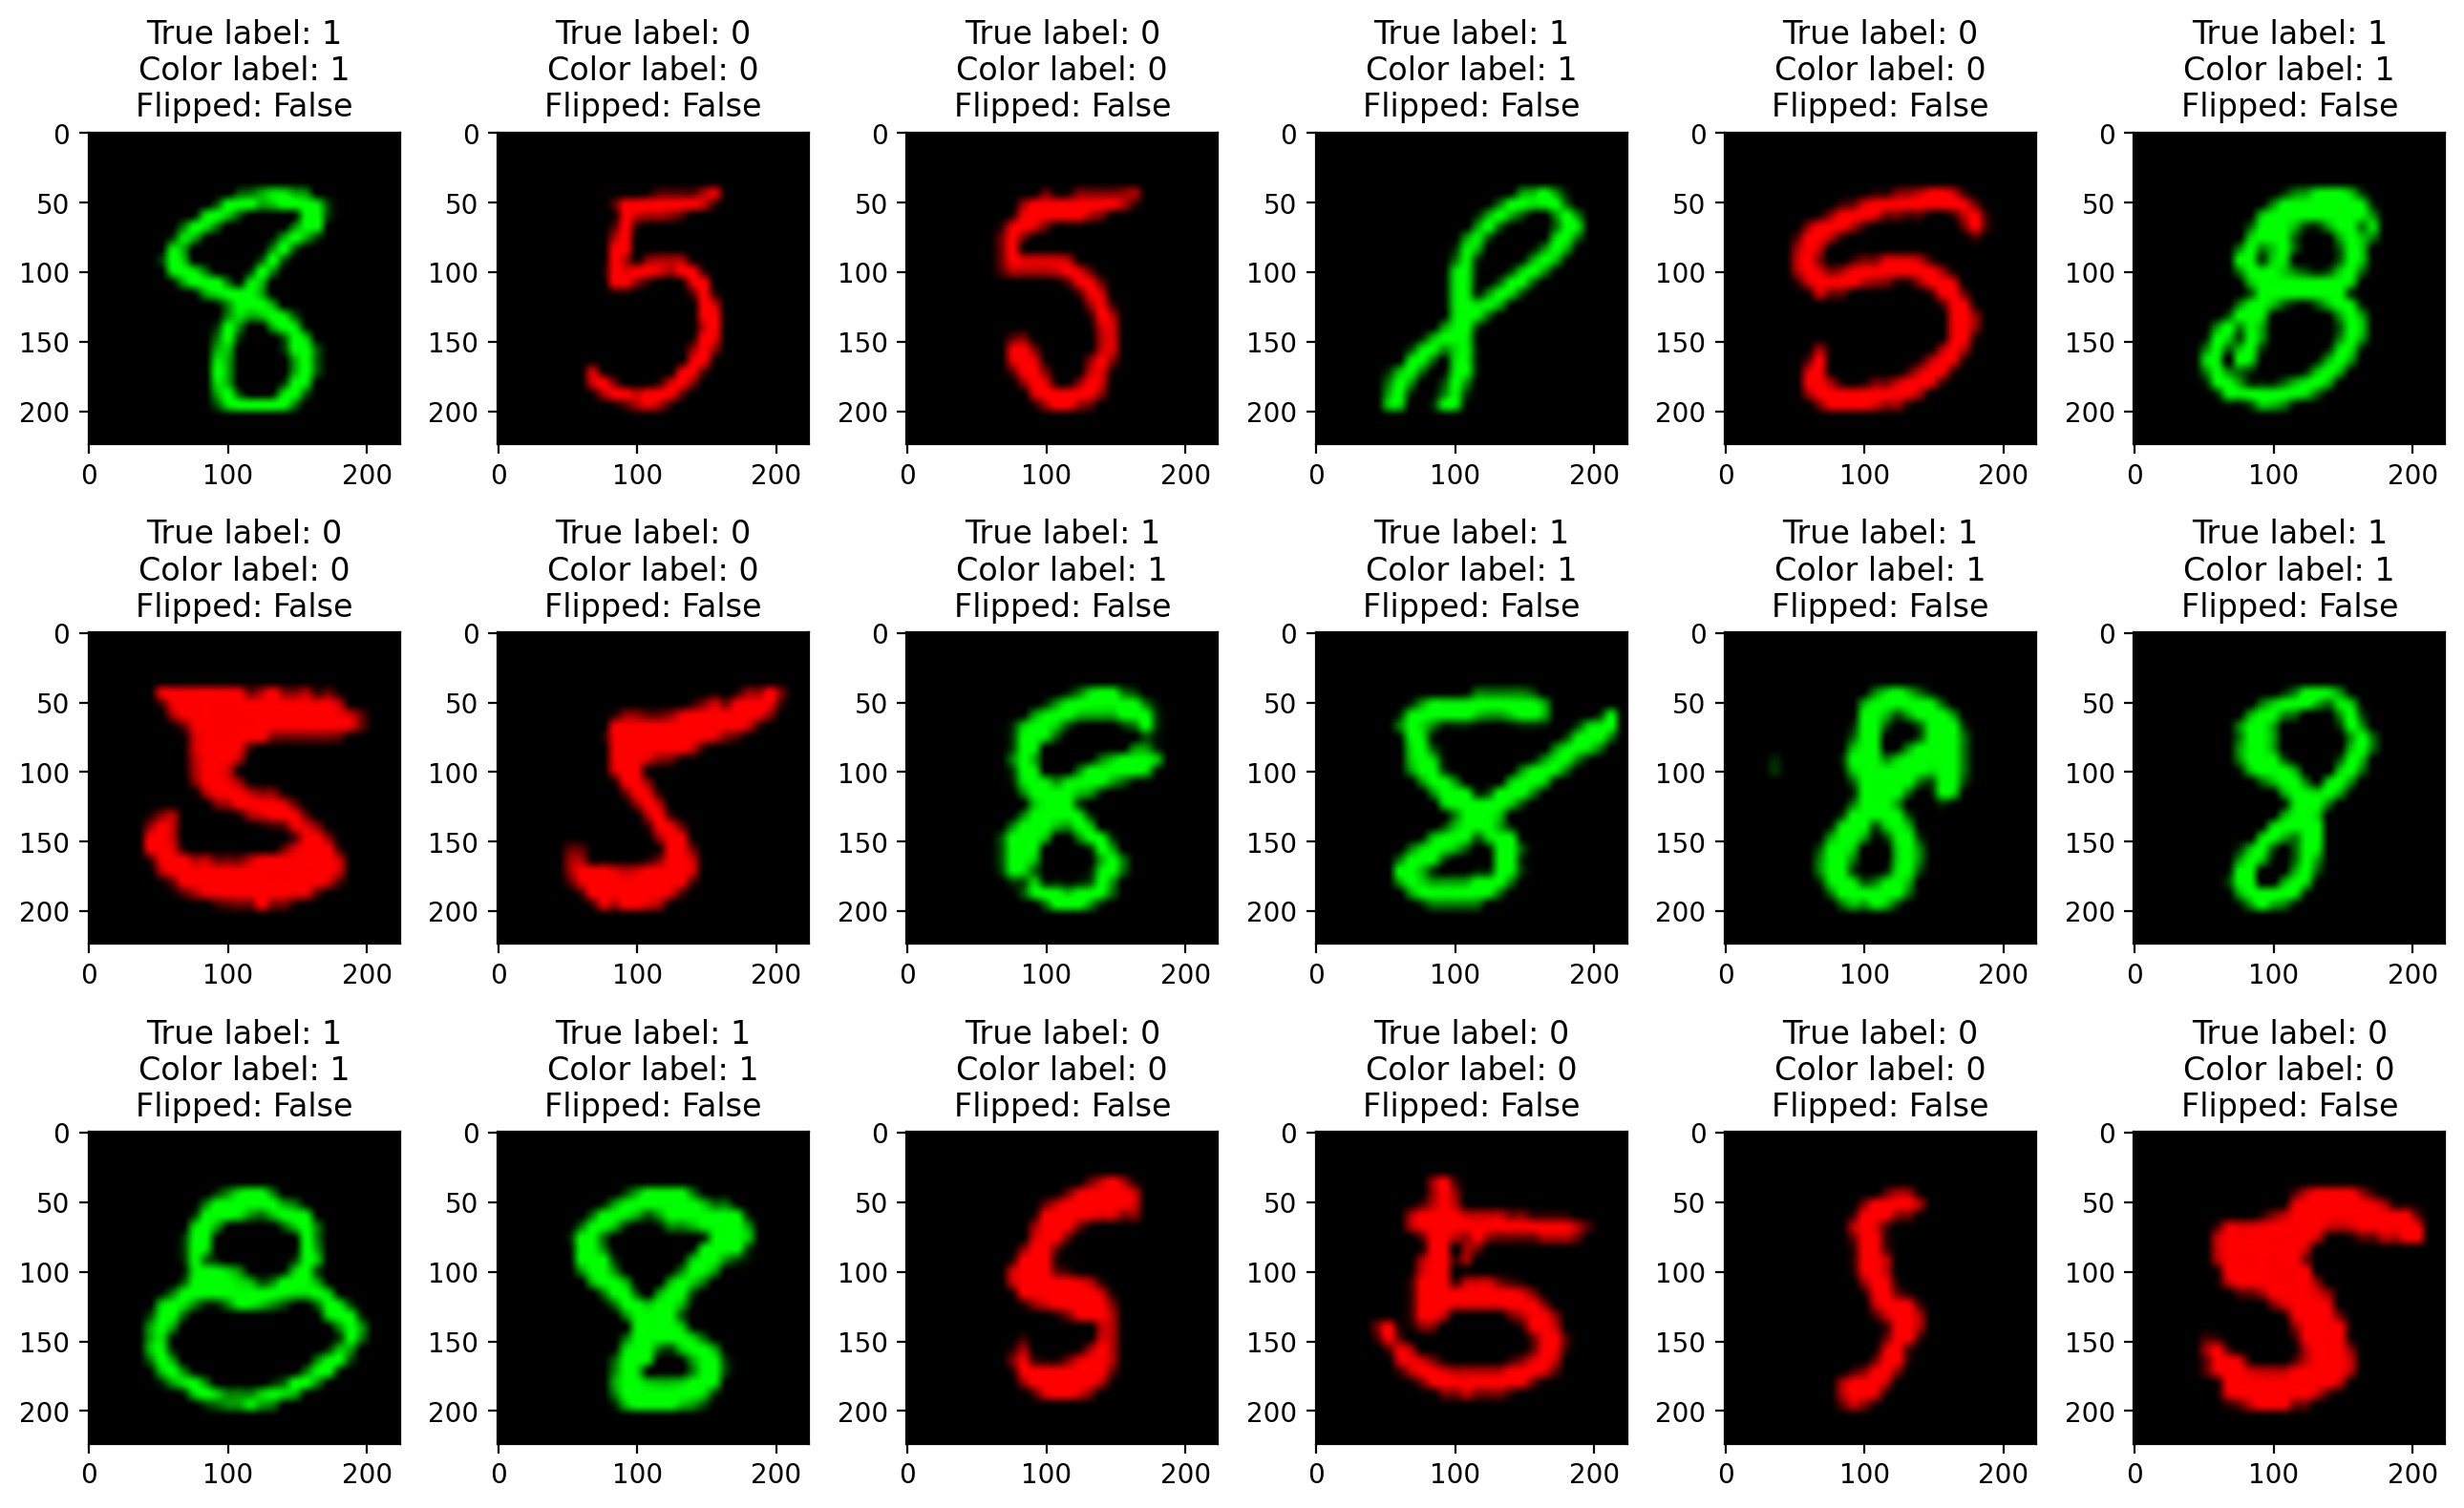

In [152]:
# create and select validation dataset
# original 10 class problem
DatasetMNIST(root='./data',
                            env='val',
                            color=True,
                            opt_postfix="10classes",
                            first_color_max_nr=4,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
DatasetMNIST(root='./data',
                            env='val',
                            color=False,
                            opt_postfix="10classes",
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
val_set = DatasetMNIST(root='./data',
                            env='val',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

val_loader = torch.utils.data.DataLoader(dataset=val_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE,
                                            num_workers=10)

print("Number of samples: ", len(val_set))
plot_digits(val_set, preprocess)

MNIST dataset already exists
MNIST dataset already exists
MNIST dataset already exists
Number of samples:  1866


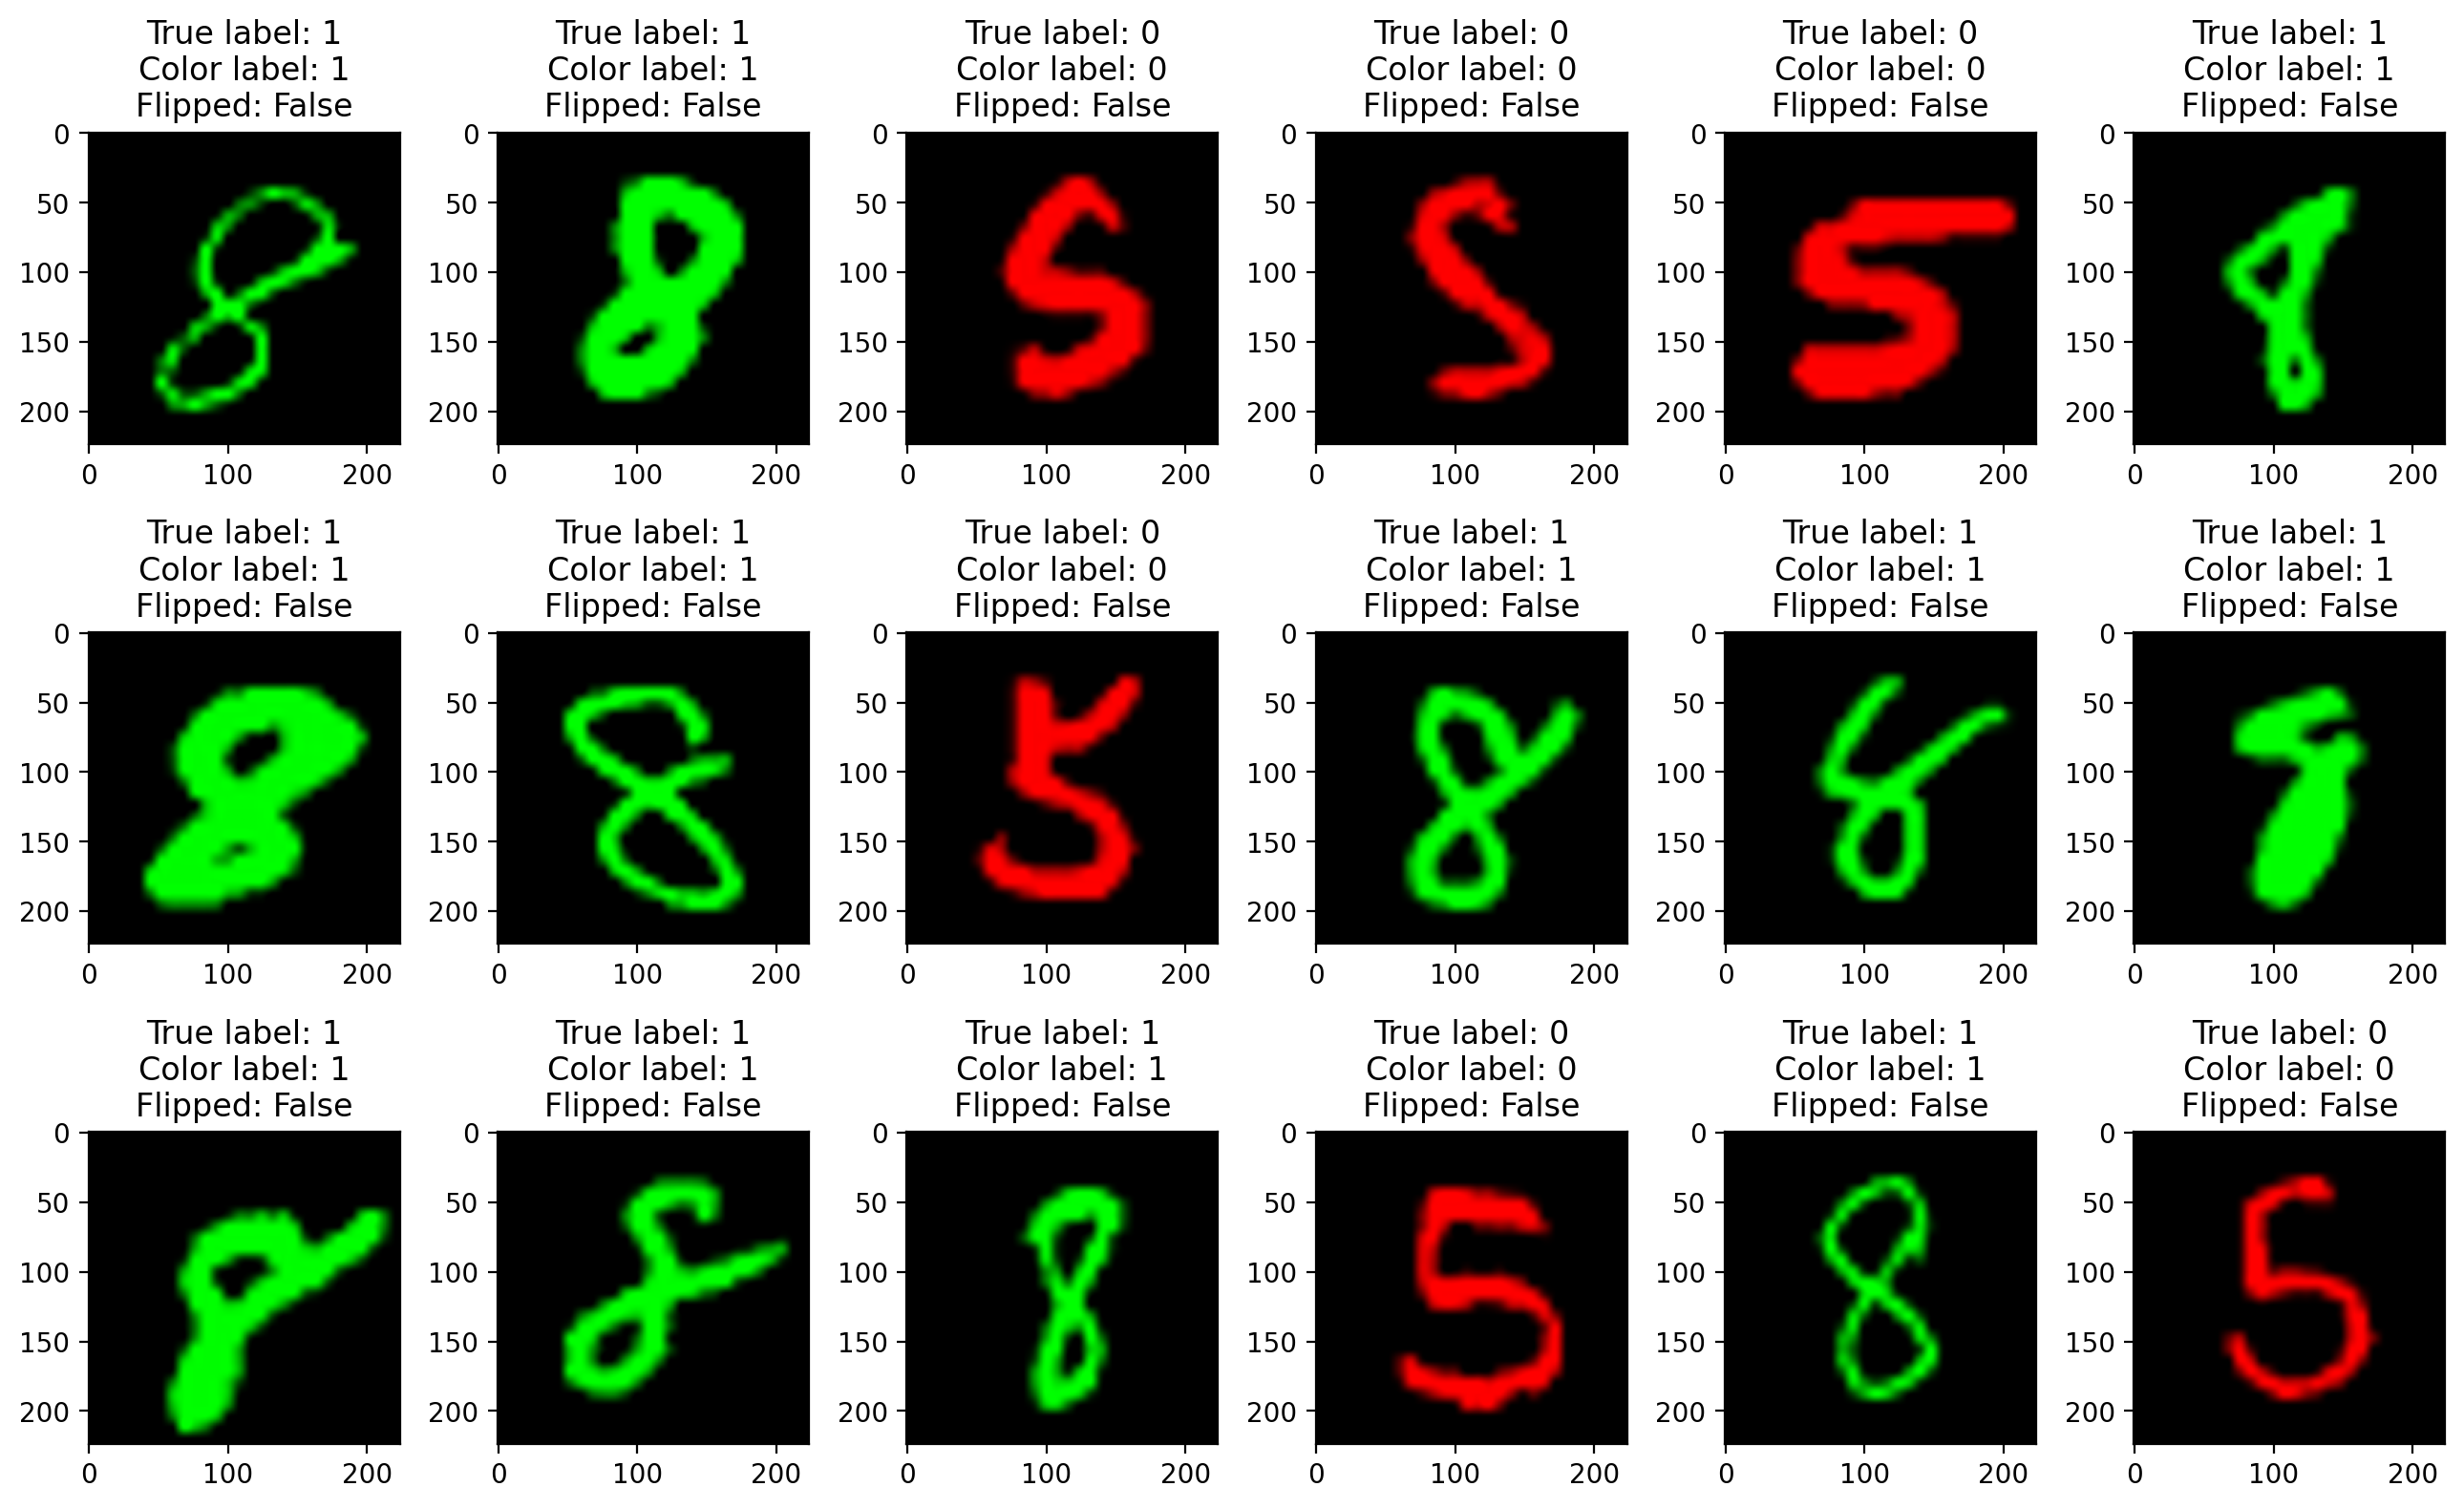

In [153]:
# create and select test dataset
# original 10 class problem
DatasetMNIST(root='./data',
                            env='test',
                            color=True,
                            opt_postfix="10classes",
                            first_color_max_nr=4,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
DatasetMNIST(root='./data',
                            env='test',
                            color=False,
                            opt_postfix="10classes",
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
test_set = DatasetMNIST(root='./data',
                            env='test',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

test_loader = torch.utils.data.DataLoader(dataset=test_set,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE,
                                            num_workers=10)

print("Number of samples: ", len(test_set))
plot_digits(test_set, preprocess)

MNIST dataset already exists
MNIST dataset already exists
MNIST dataset already exists
Number of samples:  1866


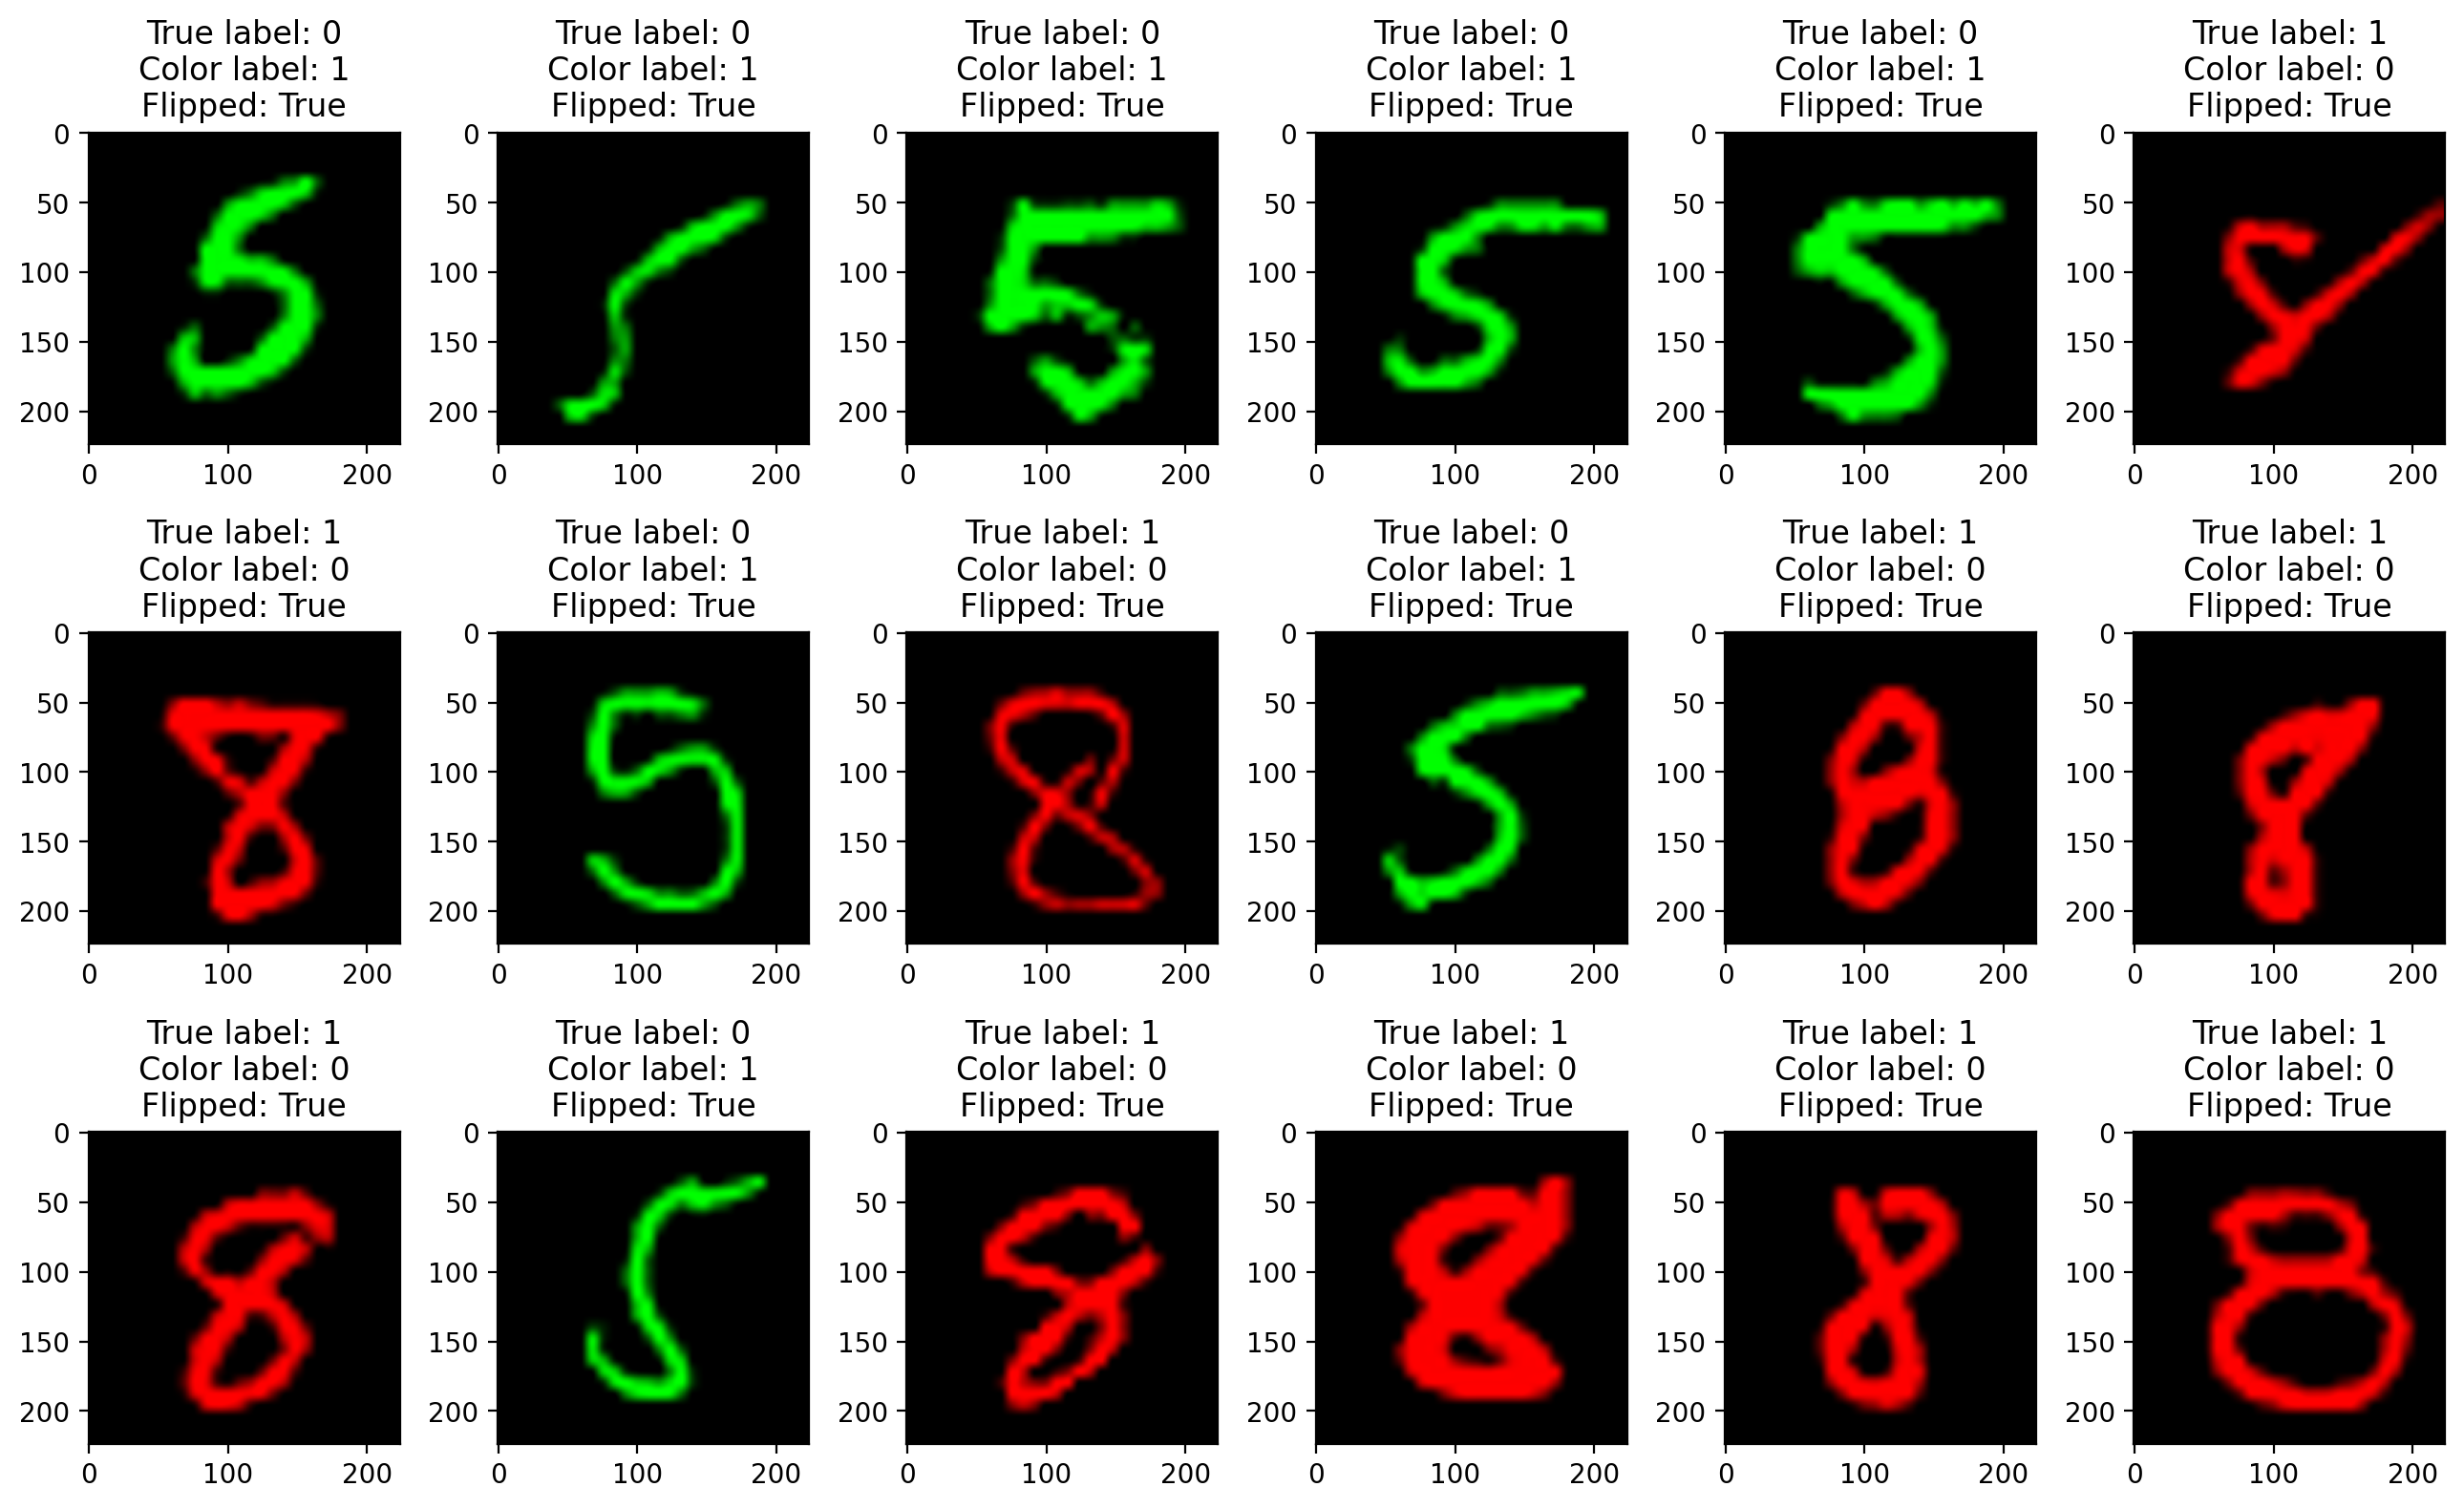

In [154]:
# create and select test_fool dataset
# original 10 class problem
DatasetMNIST(root='./data',
                            env='test_fool',
                            color=True,
                            opt_postfix="10classes",
                            first_color_max_nr=4,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

# gray 10 class problem
DatasetMNIST(root='./data',
                            env='test_fool',
                            color=False,
                            opt_postfix="10classes",
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

# simplified binary problem
test_set_fool = DatasetMNIST(root='./data',
                            env='test_fool',
                            color=True,
                            opt_postfix="2classes",
                            filter=[5,8],
                            first_color_max_nr=5,
                            preprocess=preprocess,
                            transform= transforms.Compose([transforms.ToTensor()]))

test_fool_loader = torch.utils.data.DataLoader(dataset=test_set_fool,
                                            batch_size=DATASET_BATCH_SIZE,
                                            shuffle=DATASET_SHUFFLE,
                                            num_workers=10)

print("Number of samples: ", len(test_set_fool))
plot_digits(test_set_fool, preprocess)

In [155]:
# check, if all test labels are correct (all high_low labels are equal to the color labels -> No messages expected)
for idx, i in enumerate(test_loader):
    if not ((i[2] == i[3]).all().item()):
        print("Error! in batch ", idx)

In [156]:
# check, if all test_fool labels are correct (all high_low labels are opposite to the color labels -> No messages expected)
for idx, i in enumerate(test_fool_loader):
    if not ((i[2] != i[3]).all().item()):
        print("Error! in batch ", idx)

## Set device (For number crunching)

In [157]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Initialize network

In [158]:
# Resnet50 transfer learning
# https://discuss.pytorch.org/t/how-to-modify-the-final-fc-layer-based-on-the-torch-model/766/2
model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
# replace the last fully-connected layer
# parameters of newly constructed modules have required_grad=True by default
model.fc = nn.Linear(2048, 2)
model.to(device)
model.fc.weight # initialized with random numbers - Requires grad is true

/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter containing:
tensor([[ 0.0220,  0.0159,  0.0089,  ...,  0.0045,  0.0179, -0.0185],
        [-0.0003, -0.0015, -0.0022,  ...,  0.0125,  0.0138, -0.0082]],
       device='cuda:0', requires_grad=True)

## Train network

In [159]:
def train_model(model, criterion, optimizer, num_epochs=3):
    """
    Training procedure and performance measurement of the model.
    """
    history = {'train_w_backprop'   : {'loss' : [],
                                       'acc' : []},
               'train'              : {'loss' : [],
                                       'acc' : []},
                'validation'        : {'loss' : [],
                                       'acc' : []},
                'test'              : {'loss' : [],
                                       'acc' : []},
                'test_fool'         : {'loss' : [],
                                       'acc' : []}}
        
    # epoch
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # phase
        for phase in history.keys():
            if phase == 'train_w_backprop':
                model.train()
                datasource = train_loader
            elif phase == "train":
                model.eval()
                datasource = train_loader
            elif phase == "validation":
                model.eval()
                datasource = val_loader
            elif phase == "test":
                model.eval()
                datasource = test_loader
            elif phase == "test_fool":
                model.eval()
                datasource = test_fool_loader
            else:
                raise NotImplementedError("Sorry, unknown phase!")

            epoch_loss = 0.0
            running_corrects = 0
            label_counter = 0

            # mini-batches
            for inputs, _, low_high_lables, _ in datasource:
                
                inputs = inputs.to(device)
                low_high_lables = low_high_lables.to(device)
                
                logits = model(inputs)
                preds = logits.argmax(dim=1)
                running_corrects += torch.sum(preds == low_high_lables.data)
                label_counter += low_high_lables.size()[0]
                
                batch_loss = criterion(logits, low_high_lables)
                epoch_loss += batch_loss.item()

                if phase == 'train_w_backprop':
                    optimizer.zero_grad()   # Sets the gradients of all optimized torch.Tensor to zero.
                    batch_loss.backward()   # compute gradients
                    optimizer.step()        # Performs a single optimization step (parameter update).
                
            epoch_acc = 100 * running_corrects.double() / label_counter
            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
            
            history[phase]['loss'].append(epoch_loss)
            history[phase]['acc'].append(epoch_acc.cpu())
            
    return model, history, inputs, low_high_lables, logits, batch_loss, label_counter

In [160]:
# F.sigmoid (Map values between 0 and 1) + F.binary_cross_entropy
# https://zhang-yang.medium.com/how-is-pytorchs-binary-cross-entropy-with-logits-function-related-to-sigmoid-and-d3bd8fb080e7
# https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a
#criterion = F.binary_cross_entropy_with_logits #(input, target)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=.00001)

In [161]:
model, history, inputs, labels, preds, batch_loss, label_counter = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train_w_backprop loss: 45.5644, acc: 67.8549
train loss: 40.6530, acc: 88.9232
validation loss: 8.2455, acc: 89.3434
test loss: 8.1529, acc: 89.0139
test_fool loss: 11.3129, acc: 41.4791
Epoch 2/10
----------
train_w_backprop loss: 37.0812, acc: 95.5629
train loss: 33.5469, acc: 98.8508
validation loss: 6.8065, acc: 98.7621
test loss: 6.7084, acc: 99.1426
test_fool loss: 12.9191, acc: 17.2562
Epoch 3/10
----------
train_w_backprop loss: 30.8497, acc: 99.5212
train loss: 27.8720, acc: 99.9042
validation loss: 5.6755, acc: 99.8924
test loss: 5.5626, acc: 99.9464
test_fool loss: 14.5420, acc: 3.1083
Epoch 4/10
----------
train_w_backprop loss: 25.9899, acc: 99.9255
train loss: 23.5790, acc: 99.9681
validation loss: 4.7994, acc: 99.9462
test loss: 4.7026, acc: 100.0000
test_fool loss: 16.0901, acc: 0.9646
Epoch 5/10
----------
train_w_backprop loss: 22.0480, acc: 100.0000
train loss: 20.1746, acc: 100.0000
validation loss: 4.1048, acc: 100.0000
test loss: 4.0091, acc:

In [162]:
import pickle

#pickle.dump(model, open("/home/patrick.koller/masterthesis/data/models/standalone_resnet50.mdl", 'wb'))

## Assess performance

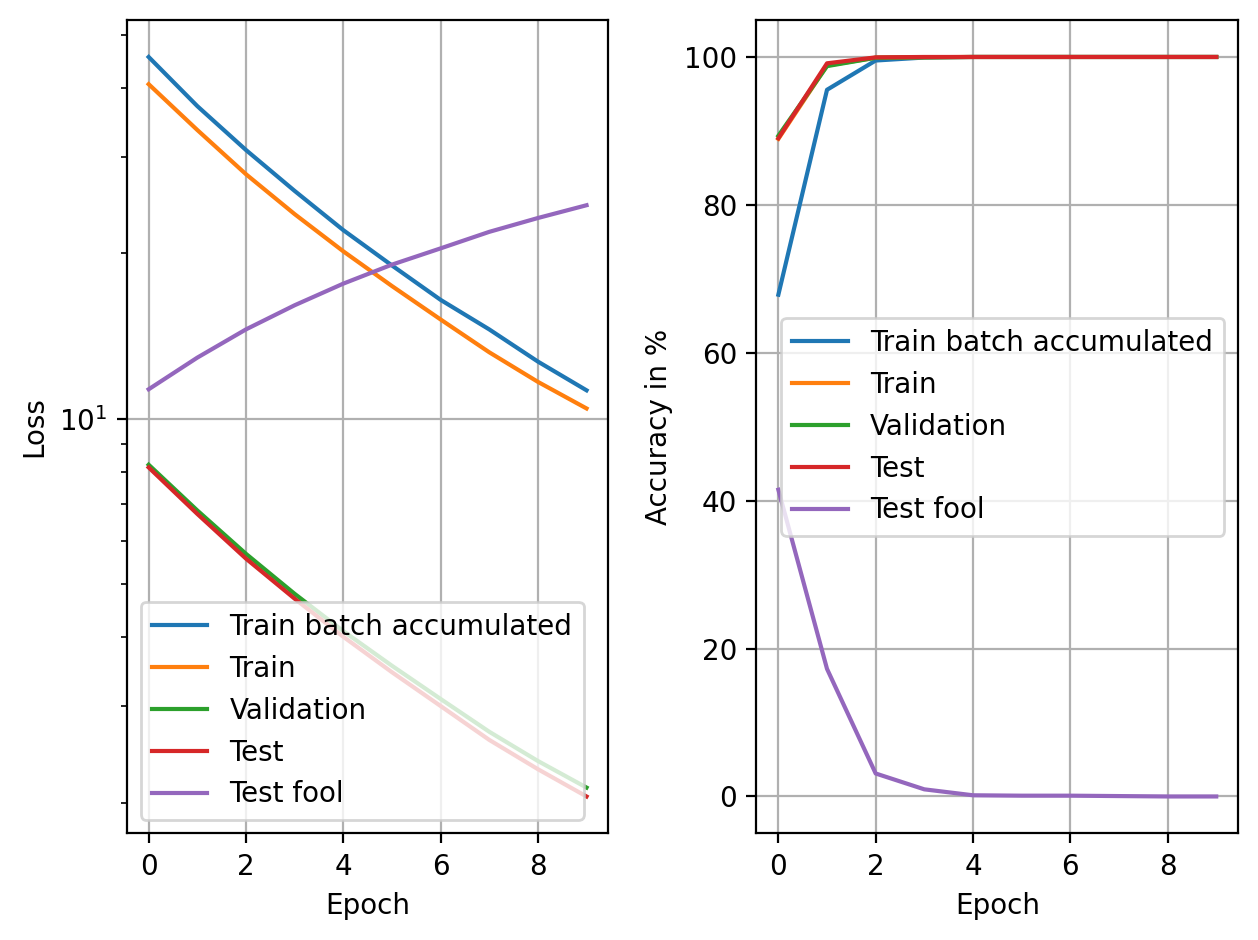

In [163]:
def plot_history(hist, show_curves=['train_w_backprop', 'train', 'validation', 'test', 'test_fool']):
    """
    Plot the losses and accuracies during the training, validation and test procedures.
    """
    plt.subplot(1,2,1)
    if 'train_w_backprop' in show_curves:
        plt.semilogy(range(len(hist['train_w_backprop']['loss'])), hist['train_w_backprop']['loss'], label='Train batch accumulated')
    if 'train' in show_curves:
        plt.semilogy(range(len(hist['train']['loss'])), hist['train']['loss'], label='Train')
    if 'validation' in show_curves:
        plt.semilogy(range(len(hist['validation']['loss'])), hist['validation']['loss'], label='Validation')
    if 'test' in show_curves:
        plt.semilogy(range(len(hist['test']['loss'])), hist['test']['loss'], label='Test')
    if 'test_fool' in show_curves:
        plt.semilogy(range(len(hist['test_fool']['loss'])), hist['test_fool']['loss'], label='Test fool')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    if 'train_w_backprop' in show_curves:
        plt.plot(range(len(hist['train_w_backprop']['acc'])), hist['train_w_backprop']['acc'], label='Train batch accumulated')
    if 'train' in show_curves:
        plt.plot(range(len(hist['train']['acc'])), hist['train']['acc'], label='Train')
    if 'validation' in show_curves:
        plt.plot(range(len(hist['validation']['acc'])), hist['validation']['acc'], label='Validation')
    if 'test' in show_curves:
        plt.plot(range(len(hist['test']['acc'])), hist['test']['acc'], label='Test')
    if 'test_fool' in show_curves:
        plt.plot(range(len(hist['test_fool']['acc'])), hist['test_fool']['acc'], label='Test fool')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy in %')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
plot_history(history, show_curves=['train_w_backprop', 'train', 'validation', 'test', 'test_fool'])

Why is the validation accuracy higher than the training accuracy?  

Answer, if a dropout layer is in use: (There is no dropout layer in resnet50)  
This is a typical behaviour when using dropout, since the behaviour during training and testing are different. When training, a percentage of the features are set to zero (50%, if dropout(0.5)). When testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies.

Answer for this resnet50:  
Most probably, the training (50000 samples) and the validation (5000 samples) datasets are not 100% i.i.d. from the same distribution (or at least they are unbalanced!) and there are some less complicated samples in the smaller dataset. This usually is the case, if the validation loss is smaller than the training loss. This hypothesis needs to be proven! This can be confirmed in a simple and easy way by switching the training and the validation (5000 samples) dataset and validate on the training (50000 samples) dataset. In this case the training loss curve (obtained with the validation dataset) is lower than the validation loss curve (obtained with the training dataset)! Of course, this is not a 100% perfect proof, but a simple and easy indicator to support this hypothesis. If this should be a problem, more analysis of the data needs to be done.

In [185]:
random_tests(train_loader, model, device, preprocess)

TypeError: random_tests() takes 3 positional arguments but 4 were given

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Batch accuracy: 100.0%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

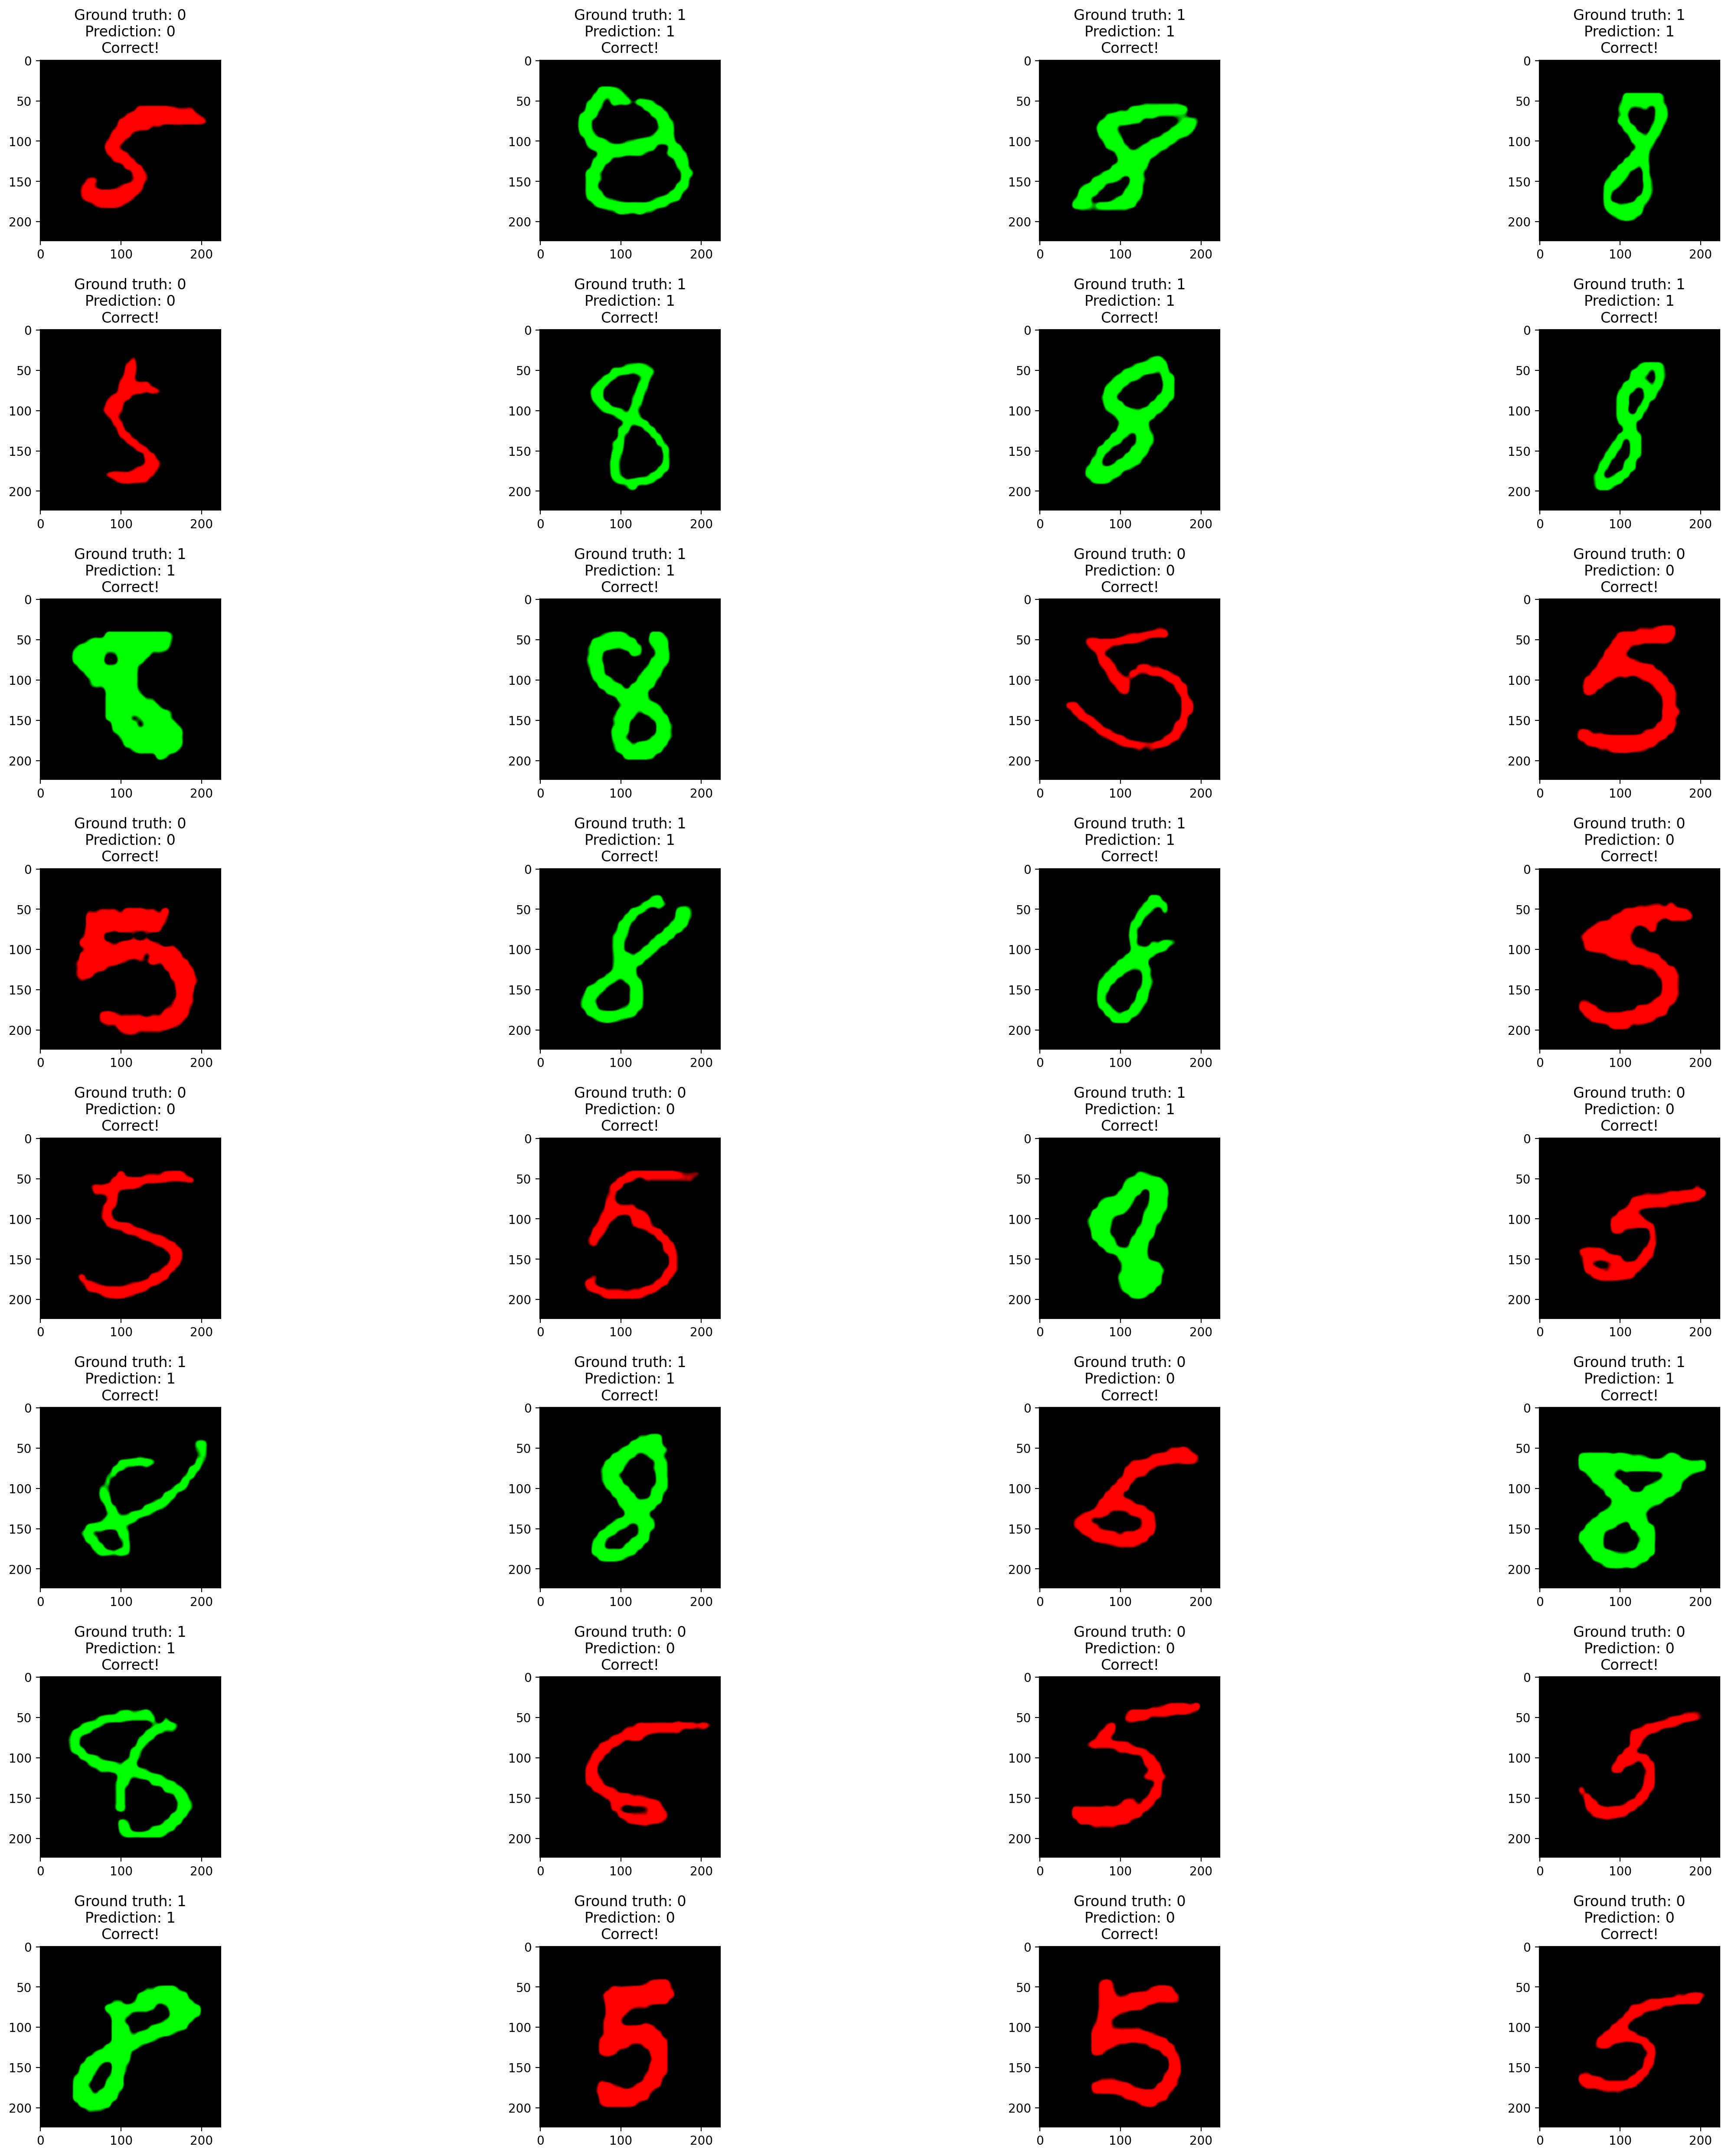

In [165]:
random_tests(val_loader, model, device, preprocess)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Batch accuracy: 100.0%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

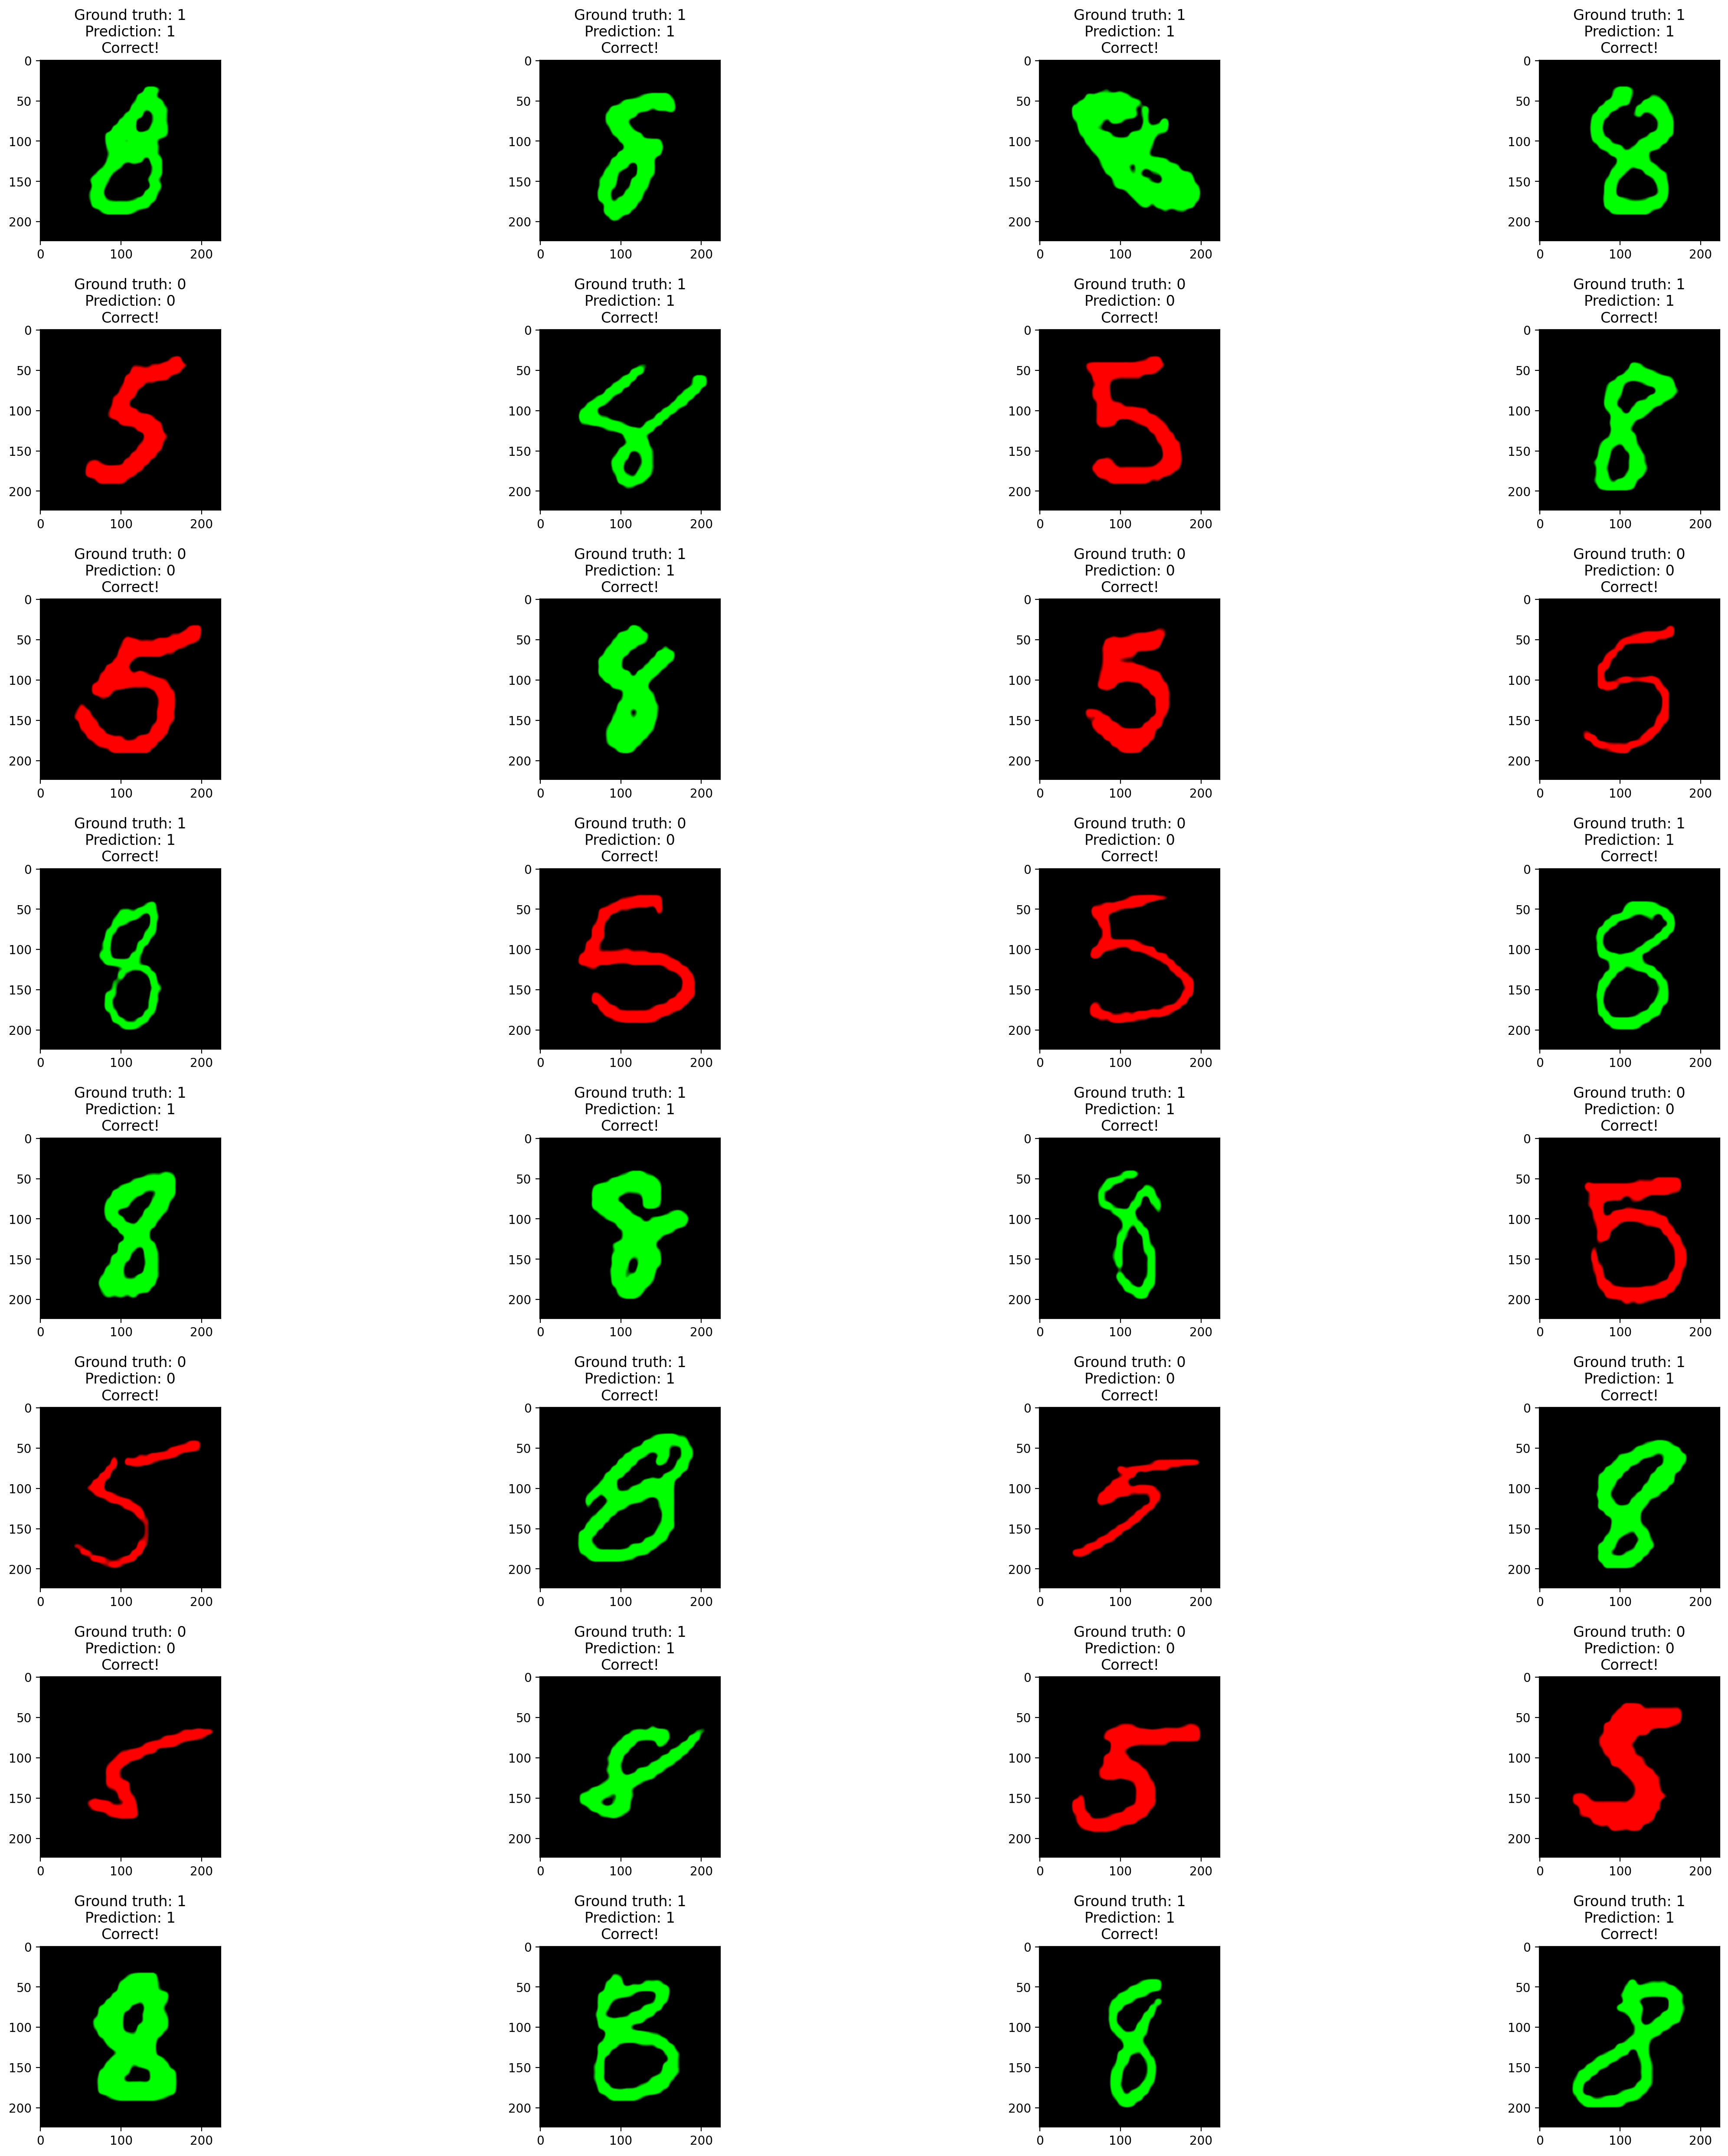

In [166]:
random_tests(test_loader, model, device, preprocess)

In [186]:
random_tests(test_fool_loader, model, device, preprocess)

TypeError: random_tests() takes 3 positional arguments but 4 were given